Heart disease prediction using Random Forests

This code is accompanied with several tips including classes, functions and methods to use. Please note that you do not have to follow these tips, but they might be handy in some cases.

Author: Polyxeni Gkontra (polyxeni.gkontra@ub.edy)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


Read the .csv file with the patient information (TIP: you can use read_csv function from pandas) 

In [4]:
df = pd.read_csv('hd_data.csv')

Explore your data. E.g. Print the file or few lines to see how it looks like (TIP: If you want to see just few lines consider function head(). Functions dtypes() and describe() are useful to check the type of the data in each column and statistical properties, respectively)

In [5]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Check statistical details on your data like counts, min, max etc

In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Check the type of the features

In [7]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Check how many patients you have from each category

Split your dataset into training and testing creating a balanced dataset (TIP: 1. You can drop patients from the majority class, 2. You can use from scikit-learn, train_test_split(), 3. Good ML practices suggest to always shuffle your data, for dataframes you can use sample but watch out to add reset_index(drop=True) to reset the idnex but avoid creating a column with the index)

In [8]:
# Drop subjects from majority class
label = 'HeartDisease'
healthy = df[df[label] == 0]
diseased = df[df[label] == 1]
print('Number of individuals from class 0 before balancing', healthy.shape[0])
print('Number of individuals from class 1 before balancing', diseased.shape[0])

# Delete the ones extra so that the number if equal
if healthy.shape[0] > diseased.shape[0]:
  healthy = healthy.iloc[0:diseased.shape[0],:]
elif healthy.shape[0] < diseased.shape[0]:
  diseased = diseased.iloc[0:healthy.shape[0],:]

print('Number of individuals of class 0 after balancing', healthy.shape[0])
print('Number of individuals of class 1 after balancing', diseased.shape[0])
# Concatenate
temp = [healthy, diseased]
df = pd.concat(temp)

# Shuffle the data 
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

# Separate features from output & convert to numpy - You can also continue in pandas 
Y = df[label].copy()
X = df.drop(label, axis=1)

# Indices of training subjects and of testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=25)

Number of individuals from class 0 before balancing 410
Number of individuals from class 1 before balancing 508
Number of individuals of class 0 after balancing 410
Number of individuals of class 1 after balancing 410


Data pre-processing 

1.   Encode categorical variables  (TIP: Check OrdinalEncoder() from sklearn.preprocessing. Another popular approaches is OneHotEncoder but not appropriate for tree based classifiers, can you imagine why?)
2.   Scale numerical data (TIP: Check MinMaxScaler())

TIP: 1. It is very important to treat testing and training data separately to avoid data leakage 2. Methods fit_transform (for training data) and tranfrom (for the testing data) from can be very helpful. Alternatively you can use Pipeline and ColumnTransformer from sklearn but it will be more complicated to retrieve feature names for the most important features



In [9]:
# Indices of categorical and numerical columns
# Categorical features
cat_feat = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina','ST_Slope']
# Indices of categorical features
categorical_idx = [loc for loc, key in enumerate(X_train.columns) if key in cat_feat]
# Indices of columns with numerical data
numerical_idx = list(set(range(0,X_train.shape[1])) - set(categorical_idx))
# Names of numerical features 
num_feat = X_train.columns[numerical_idx]

# Handle categorical variables
cat_preprocesssor = OrdinalEncoder()
X_train[cat_feat] = cat_preprocesssor.fit_transform(X_train[cat_feat])
X_test[cat_feat] = cat_preprocesssor.transform(X_test[cat_feat])
# Normalize the numerical valyes
num_preprocesssor = MinMaxScaler()
X_train[num_feat] = num_preprocesssor.fit_transform(X_train[num_feat])
X_test[num_feat] = num_preprocesssor.transform(X_test[num_feat])

Train the model (TIP: Check method fit)

In [10]:
# Random forest classifier with 500 trees, random_state is set to be able to reproduce your results
estimator = RandomForestClassifier(100, max_depth=10, random_state=42)
estimator.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, random_state=42)

Apply the model to the testing data and evaluate its perfromance (TIP: You might use classification_report or roc_auc_score)

In [11]:
# Make the prediction
Y_pred = estimator.predict(X_test)
# Evaluate the performance by comparing the predicted labels with the true ones
print(classification_report(Y_test,Y_pred))
accuracy = accuracy_score(Y_test,Y_pred)
print(f"The accuracy is {accuracy}")


              precision    recall  f1-score   support

           0       0.92      0.86      0.89        79
           1       0.88      0.93      0.90        85

    accuracy                           0.90       164
   macro avg       0.90      0.90      0.90       164
weighted avg       0.90      0.90      0.90       164

The accuracy is 0.8963414634146342


Get the feature importance in the model's estimation and plot the most important features (TIP: To get feature importance and names you can use feature_importances_ and feature_names_in attributes of your model, respectively)

Text(0.5, 0, "Feature Importance for model's decision")

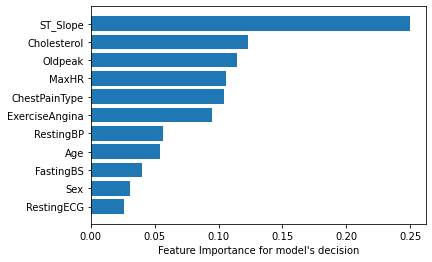

In [12]:
# Sort the feature in descending order of importance
sorted_idx = estimator.feature_importances_.argsort()
plt.barh(estimator.feature_names_in_[sorted_idx], estimator.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance for model's decision")
